# Modelo de red neuronal convolucional base (35 capas)

En este notebook construiremos un modelo de red neuronal convolucional con 35 capas entrenables, inspirado en la arquitectura ResNet-50, pero sin conexiones residuales. Los detalles del entrenamiento y de los datos pueden ser consultados en el notebook "./ResNet-50.ipynb".

### Preparación de los datos

In [1]:
# Importamos las paqueterías necesarias para el notebook
import time
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# De ser posible utilizaremos GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=False,
                test=False):
    """
    Función para cargar los datos de CIFAR-10
    """
    
    # Definimos el transform para normalizar los datos con pytorch
    # Los valores fueron obtenidos en el notebook "data_extraction.ipynb"
    normalize = transforms.Normalize(  
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # Definimos el transform para preporcesar los datos
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    
    # Obtener los datos del conjunto de prueba
    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform_test,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # Cargamos una copia de los datos de entrenamiento
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Cargamos una copia extra de los datos de entrenamiento para dividirlo después en el conjunto de validación
    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Separamos los datos de entrenamiento y validación mediante índices
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # Finalmente, definimos los conjuntos de entrenamiento y validación
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# Aplicamos la función para cargar los datos de CIFAR-10, los guardamos en el directorio actual
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)    
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Definición del modelo

La estructura del modelo es la misma que ResNet-50, sin conexiones residuales y con stages de 2,3,4,2 bloques Bottleneck respectivamente. Como el modelo empieza con una capa convolucional, cada bloque Bottleneck tiene 3 capas convolucionales y el modelo termina con una capa lineal, este modelo tiene un total de 1+(2+3+4+2)\*3+1=35 capas entrenables

In [3]:
class ConvNet_35_capas(nn.Module):
    """
    Modelo de red neuronal convolucional de 35 capas para clasificar imágenes en 10 clases posibles
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        
        self.bloc1 = nn.Sequential(nn.Conv2d(64, 16, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 16, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 64, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU()
                                   )
        self.conv_down2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  #  feature map size = (16,16)
                                        nn.BatchNorm2d(128),
                                        nn.ReLU()
                                       )
        
        self.bloc2 = nn.Sequential(nn.Conv2d(128, 32, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   nn.Conv2d(32, 32, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   nn.Conv2d(32, 128, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU()
                                  )
        
        self.conv_down3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  #  feature map size = (8,8)
                                        nn.BatchNorm2d(256),
                                        nn.ReLU())
        
        self.bloc3 = nn.Sequential(nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1),  
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),  
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   )
        
        self.conv_down4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  #  feature map size = (4,4)
                                        nn.BatchNorm2d(512),
                                        nn.ReLU())
        
        self.bloc4 = nn.Sequential(nn.Conv2d(512, 128, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.Conv2d(128, 512, kernel_size=3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU()
                                  )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512,10)


    def forward(self,x):
        out = self.conv1(x)
        for i in range(2):
            out = self.bloc1(out)
        out = self.conv_down2(out)
        for i in range(3):
            out = self.bloc2(out)
        out = self.conv_down3(out)
        for i in range(4):
            out = self.bloc3(out)
        out = self.conv_down4(out)
        for i in range(2):
            out = self.bloc4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = F.softmax(out, dim = 1)
        return out

### Entrenamiento

In [4]:
def entrenamiento():
    # variables para guardar los resultados
    accuracy_training_epochs = []
    accuracy_validation_epochs = []
    loss_epoch = []
    test_accuracy = []
    
    # hiperparámetros
    num_epochs = 90

    model = ConvNet_35_capas().to(device)

    optimizer = optim.SGD(
            params=model.parameters(),
            lr=0.1,
            momentum=0.9,
            weight_decay=0.0001)
    
    criterion = nn.CrossEntropyLoss()
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=60, gamma=0.1)

    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)
    
    # entrenamiento
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, (images, labels) in enumerate(train_loader):

            # Mover a los tensores a GPU de ser posible
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass y descenso de gradiente estocástico
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Ahorro de memoria
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

        loss_epoch.append(loss.item())
        lr_scheduler.step() # Implementación de learning rate decay

        # Exactitud en el conjunto de validación
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            val_accuracy = correct/total
            accuracy_validation_epochs.append(val_accuracy)

        # Exactitud en el total del conjunto de entrenamiento
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            train_accuracy = correct/total
            accuracy_training_epochs.append(train_accuracy)

        # Exactitud en el conjunto de prueba
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            t_acc = correct/total
            test_accuracy.append(t_acc)



        print(f"Epoch [{epoch+1}/{num_epochs}], Training accuracy: {round(train_accuracy,3)}, Validation accuracy: {round(val_accuracy,3)}, loss = {round(loss_epoch[-1],3)}")
        print(f"Time spent on epoch {epoch+1}: {round((time.time()-start_time)/60,2)}min")
        
    return [model,
            accuracy_training_epochs,
            accuracy_validation_epochs,
            test_accuracy,
            loss_epoch]  # model, training accuracy, validation accuracy, test accuracy, loss

In [5]:
# repetimos 3 veces el experimento
model1, training1, validation1, test1, loss1 = entrenamiento()
model2, training2, validation2, test2, loss2 = entrenamiento()
model3, training3, validation3, test3, loss3 = entrenamiento()

Epoch [1/90], Training accuracy: 0.13, Validation accuracy: 0.128, loss = 2.358
Time spent on epoch 1: 3.12min
Epoch [2/90], Training accuracy: 0.217, Validation accuracy: 0.216, loss = 2.184
Time spent on epoch 2: 2.81min
Epoch [3/90], Training accuracy: 0.21, Validation accuracy: 0.214, loss = 2.396
Time spent on epoch 3: 3.01min
Epoch [4/90], Training accuracy: 0.225, Validation accuracy: 0.221, loss = 2.074
Time spent on epoch 4: 2.97min
Epoch [5/90], Training accuracy: 0.22, Validation accuracy: 0.22, loss = 2.2
Time spent on epoch 5: 3.03min
Epoch [6/90], Training accuracy: 0.233, Validation accuracy: 0.238, loss = 2.053
Time spent on epoch 6: 3.08min
Epoch [7/90], Training accuracy: 0.215, Validation accuracy: 0.213, loss = 2.332
Time spent on epoch 7: 3.12min
Epoch [8/90], Training accuracy: 0.259, Validation accuracy: 0.259, loss = 2.255
Time spent on epoch 8: 3.16min
Epoch [9/90], Training accuracy: 0.279, Validation accuracy: 0.273, loss = 2.18
Time spent on epoch 9: 3.22min

Epoch [74/90], Training accuracy: 0.55, Validation accuracy: 0.544, loss = 1.937
Time spent on epoch 74: 3.78min
Epoch [75/90], Training accuracy: 0.555, Validation accuracy: 0.541, loss = 2.053
Time spent on epoch 75: 3.63min
Epoch [76/90], Training accuracy: 0.553, Validation accuracy: 0.541, loss = 1.941
Time spent on epoch 76: 3.72min
Epoch [77/90], Training accuracy: 0.559, Validation accuracy: 0.549, loss = 2.159
Time spent on epoch 77: 3.68min
Epoch [78/90], Training accuracy: 0.564, Validation accuracy: 0.543, loss = 1.977
Time spent on epoch 78: 3.67min
Epoch [79/90], Training accuracy: 0.568, Validation accuracy: 0.556, loss = 1.939
Time spent on epoch 79: 3.66min
Epoch [80/90], Training accuracy: 0.57, Validation accuracy: 0.541, loss = 1.955
Time spent on epoch 80: 3.57min
Epoch [81/90], Training accuracy: 0.573, Validation accuracy: 0.559, loss = 2.205
Time spent on epoch 81: 3.73min
Epoch [82/90], Training accuracy: 0.58, Validation accuracy: 0.568, loss = 2.184
Time spen

Epoch [57/90], Training accuracy: 0.369, Validation accuracy: 0.369, loss = 2.017
Time spent on epoch 57: 3.36min
Epoch [58/90], Training accuracy: 0.427, Validation accuracy: 0.42, loss = 2.212
Time spent on epoch 58: 3.37min
Epoch [59/90], Training accuracy: 0.427, Validation accuracy: 0.415, loss = 2.439
Time spent on epoch 59: 3.36min
Epoch [60/90], Training accuracy: 0.392, Validation accuracy: 0.384, loss = 2.146
Time spent on epoch 60: 3.38min
Epoch [61/90], Training accuracy: 0.482, Validation accuracy: 0.466, loss = 2.157
Time spent on epoch 61: 3.29min
Epoch [62/90], Training accuracy: 0.494, Validation accuracy: 0.487, loss = 2.173
Time spent on epoch 62: 3.26min
Epoch [63/90], Training accuracy: 0.495, Validation accuracy: 0.478, loss = 1.951
Time spent on epoch 63: 3.24min
Epoch [64/90], Training accuracy: 0.503, Validation accuracy: 0.492, loss = 2.049
Time spent on epoch 64: 3.17min
Epoch [65/90], Training accuracy: 0.512, Validation accuracy: 0.495, loss = 1.833
Time sp

Epoch [40/90], Training accuracy: 0.42, Validation accuracy: 0.41, loss = 2.184
Time spent on epoch 40: 5.22min
Epoch [41/90], Training accuracy: 0.418, Validation accuracy: 0.408, loss = 1.939
Time spent on epoch 41: 4.39min
Epoch [42/90], Training accuracy: 0.432, Validation accuracy: 0.429, loss = 2.058
Time spent on epoch 42: 4.44min
Epoch [43/90], Training accuracy: 0.422, Validation accuracy: 0.403, loss = 2.138
Time spent on epoch 43: 5.17min
Epoch [44/90], Training accuracy: 0.429, Validation accuracy: 0.425, loss = 2.085
Time spent on epoch 44: 6.15min
Epoch [45/90], Training accuracy: 0.477, Validation accuracy: 0.468, loss = 1.962
Time spent on epoch 45: 4.83min
Epoch [46/90], Training accuracy: 0.461, Validation accuracy: 0.448, loss = 2.202
Time spent on epoch 46: 4.45min
Epoch [47/90], Training accuracy: 0.452, Validation accuracy: 0.446, loss = 2.087
Time spent on epoch 47: 3.81min
Epoch [48/90], Training accuracy: 0.465, Validation accuracy: 0.455, loss = 2.157
Time spe

In [6]:
# guardar uno de los modelos
torch.save(model1,"./model_ConvNet-35.pt")

### Resultados

In [8]:
# Guardar en csv
results_dict1 = {"loss": loss1,
    'Train':training1,
     'Validation': validation1,
     "Test":test1}
results_dict2 = {"loss": loss2,
    'Train':training2,
     'Validation': validation2,
     "Test":test2}
results_dict3 = {"loss": loss3,
    'Train':training3,
     'Validation': validation3,
     "Test":test3}

pd.DataFrame(results_dict1).to_csv("./results/results_ConvNet35_1.csv",index=False)
pd.DataFrame(results_dict2).to_csv("./results/results_ConvNet35_2.csv",index=False)
pd.DataFrame(results_dict3).to_csv("./results/results_ConvNet35_3.csv",index=False)

In [9]:
results1 = pd.DataFrame(results_dict1)
results2 = pd.DataFrame(results_dict2)
results3 = pd.DataFrame(results_dict3)

In [10]:
# Accuracy 
accuracy = (results1["Test"].max() + results2["Test"].max() + results3["Test"].max())/3
print(accuracy)

0.5946333333333333


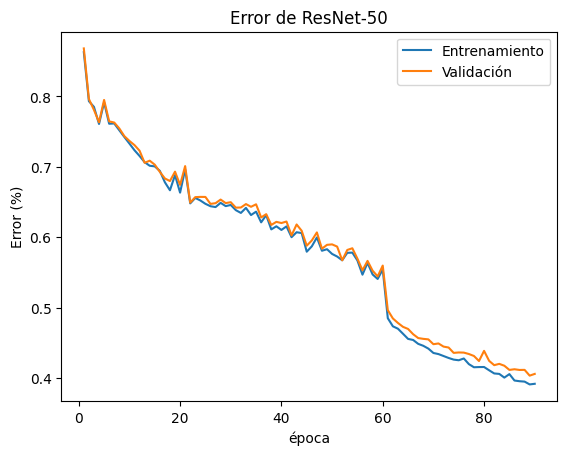

In [11]:
# graficar resultados
x_axis = np.arange(90)+1
validation_err = 1- (np.array(validation1) + np.array(validation2) + np.array(validation3) )/3
train_err = 1- (np.array(training1)+np.array(training2)+np.array(training3))/3

plt.plot(x_axis, train_err)
plt.plot(x_axis, validation_err)
# plt.plot(x_axis, np.ones(90)*0.5, 'k--', linewidth = 0.5)
plt.title("Error de ResNet-50")
plt.ylabel('Error (%)')
plt.xlabel('época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()
plt.close()

In [ ]:
# Fin